# Integrantes

- Vicente Rosales
- Nicolas Fuentes

## Codigo

In [3]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import matplotlib.pyplot as plt
import math
import ast

# Funciones

In [ ]:
# ---- Header ---- #

# def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha=0.5)

# def sigmoide(x)

# def binarizar(cont)

# def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, alpha, h_max=5.0, h_min=0.0)

# def leer_instancia_mkp(archivo) 

# def convert_list_string(s)

# ---- Header ---- #

def convert_list_string(s):
    # Primero verifica si ya es una lista (no string)
    if isinstance(s, list):
        return [int(x) if isinstance(x, (np.int64, np.int32)) else x for x in s]
    
    # Si es string, procesarlo
    try:
        # Elimina los np.int64() dejando solo los números
        cleaned = s.replace("np.int64(", "").replace(")", "")
        # Convierte el string a lista literal
        return [int(x) for x in ast.literal_eval(cleaned)]
    except:
        # Si falla, usa expresión regular como último recurso
        import re
        numbers = re.findall(r"-?\d+", s)
        return [int(x) for x in numbers]

def leer_instancia_mkp(archivo):
    """
    Lee una instancia de MKP desde un archivo en formato OR-Library.
    Retorna: n_items, n_dims, valores, pesos (n_items x n_dims), capacidades
    """
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    idx = 0
    bloques = int(lineas[idx])  # bloques de ítems (por si se usa)
    idx += 1

    n_items, n_dims, _ = map(int, lineas[idx].split())
    idx += 1

    # Leer valores de los ítems
    valores = []
    while len(valores) < n_items:
        valores.extend(map(int, lineas[idx].split()))
        idx += 1

    # Leer pesos por dimensión
    pesos = []
    for d in range(n_dims):
        pesos_dim = []
        while len(pesos_dim) < n_items:
            pesos_dim.extend(map(int, lineas[idx].split()))
            idx += 1
        pesos.append(pesos_dim)
    pesos = np.array(pesos).T  # convertir a (n_items x n_dims)

    # Leer capacidades
    capacidades = []
    while len(capacidades) < n_dims:
        capacidades.extend(map(int, lineas[idx].split()))
        idx += 1

    return n_items, n_dims, np.array(valores), pesos, np.array(capacidades)
def sigmoide(x):
    """Función sigmoide logística."""
    return 1.0 / (1.0 + np.exp(-x))

def binarizar(cont):
    """
    Convierte un vector continuo a binario usando sigmoid + criterio probabilístico.
    cont: array de floats
    retorna: array de 0/1
    """
    prob = sigmoide(cont)
    return (np.random.rand(*cont.shape) < prob).astype(int)

def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha):
    """
    Calcula el fitness de una solución binaria para MKP con penalización.
    sol_bin: vector 0/1 de selección de ítems
    valores: vector de valores de cada ítem
    pesos: matriz (n_items x n_dims) de pesos
    capacidades: vector de capacidades por dimensión
    alpha: factor de penalización
    retorna: fitness (float), es_factible (bool)
    """
    total_valor = np.dot(sol_bin, valores)
    peso_total = pesos.T.dot(sol_bin)
    exceso = np.maximum(0, peso_total - capacidades)
    penalizacion = alpha * exceso.sum()
    fitness = total_valor - penalizacion
    factible = np.all(exceso <= 0)
    return fitness, factible

def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, alpha, h_max=5.0, h_min=0.0):
    """
    Spotted Hyena Optimizer (binario) para MKP.
    Retorna:
      mejor_bin: vector binario de la mejor solución
      mejor_fitness: fitness de la mejor solución
      presa_inicial: mejor fitness en la población inicial
      mejor_presa: mejor fitness encontrado a lo largo de todas las iteraciones
      peor_presa: peor fitness encontrado a lo largo de todas las iteraciones
    """
    
    valores_hienas = []
    n_items = len(valores)
    
    # 1. Inicializar población continua en [-1,1]
    poblacion_cont = np.random.uniform(-1, 1, size=(n_hienas, n_items))
    
    # 2. Evaluar población inicial
    presa_inicial = -np.inf
    mejor_presa = -np.inf
    peor_presa =  np.inf
    mejor_bin = np.zeros(n_items, dtype=int)
    mejor_fitness = -np.inf
    mejor_cont = None
    
    for i in range(n_hienas):
        cont = poblacion_cont[i]
        binario = binarizar(cont)
        fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
        presa_inicial = max(presa_inicial, fitness)
        mejor_presa = max(mejor_presa, fitness)
        peor_presa = min(peor_presa, fitness)
        if fitness > mejor_fitness:
            mejor_fitness = fitness
            mejor_bin = binario.copy()
            mejor_cont = cont.copy()

        if fitness not in valores_hienas:
            valores_hienas.append(fitness)
        
    # 3. Bucle de iteraciones
    for it in range(max_iter):
        # 3.1 actualizar factor de exploración/explotación
        h = h_max - (it * (h_max - h_min) / max_iter)
        
        # 3.2 evaluar cada hiena y actualizar presas
        for i in range(n_hienas):
            cont = poblacion_cont[i]
            binario = binarizar(cont)
            fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
            mejor_presa = max(mejor_presa, fitness)
            peor_presa = min(peor_presa, fitness)
            if fitness > mejor_fitness:
                mejor_fitness = fitness
                mejor_bin = binario.copy()
                mejor_cont = cont.copy()
        
        # 3.3 mover hienas alrededor de la presa
        for i in range(n_hienas):
            if mejor_cont is None:
                break
            X = poblacion_cont[i]
            r1 = np.random.rand(n_items)
            r2 = np.random.rand(n_items)
            B = 2.0 * r1
            E = 2.0 * h * r2 - h
            D = np.abs(B * mejor_cont - X)
            poblacion_cont[i] = mejor_cont - E * D
    
    print("=========== INFO FINAL ===========")
    print("Presa inicial:", presa_inicial)
    print("Mejor presa  :", mejor_presa)
    print("Peor presa   :", peor_presa)
    print("delta        :", np.abs(mejor_presa - presa_inicial))
    print()

    return mejor_bin, mejor_fitness, presa_inicial, mejor_presa, peor_presa, factible, valores_hienas

In [5]:
# Parámetros
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_items = 10       # Número de ítems
n_dims = 3         # Número de restricciones (en el fondo son las dimensiones)
n_hienas = 40      # Tamaño de la población
max_iter = 100     # Número de iteraciones

# Leer instancia fácil
n_items_faciles, n_dims_faciles, valores_faciles, pesos_faciles, capacidades_faciles = leer_instancia_mkp("Instancias/mknapcb1.txt")

# Leer instancia media
n_items_dificiles, n_dims_media, valores_media, pesos_media, capacidades_media = leer_instancia_mkp("Instancias/mknapcb5.txt")

# Leer instancia difícil
n_items_dificiles, n_dims_dificiles, valores_dificiles, pesos_dificiles, capacidades_dificiles = leer_instancia_mkp("Instancias/mknapcb9.txt")

## Pruebas

### Generales

In [52]:
results = []
instancias_txt = {
    'Fácil': 'Instancias/mknapcb1.txt',
    'Media': 'Instancias/mknapcb5.txt',
    'Difícil': 'Instancias/mknapcb9.txt',
}

# --- Parametros de la optimización --- #
n_runs = 10
n_hienas = 1000
max_iter = 1000
alpha = 2
# ------------------------------------- #

for nombre, archivo in instancias_txt.items():
    n_items, n_dims, valores, pesos, capacidades = leer_instancia_mkp(archivo)
    for _ in range(n_runs):
        
        # Inicializar seguimiento de tiempo y memoria
        tiempo_inicio = time.time()
        memoria_inicio = tracemalloc.start() 

        mejor_bin, mejor_valor, presa_inicial, mejor_presa, peor_presa, factible, lista_valores = sho_binario(
            valores, pesos, capacidades, n_hienas, max_iter, alpha
        )

        # Finalizar seguimiento de tiempo y memoria
        actual, peak = tracemalloc.get_traced_memory()
        tiempo_final = time.time()
        tiempo_ejecucion = tiempo_final - tiempo_inicio
        memoria_utilizada = peak / (1024 * 1024)
        tracemalloc.stop()

        # Calcular delta
        delta = mejor_valor - presa_inicial

        results.append({
            'Instancia': nombre,
            'Mejor': mejor_valor,
            'Presa inicial': presa_inicial,
            'Delta': delta,
            'Factibilidad': factible,
            'Tiempo de ejecución': tiempo_ejecucion,
            'Memoria utilizada (MB)': memoria_utilizada,
            'Valores de las presas': lista_valores
        })

# Pasar a DataFrame
df_resultados = pd.DataFrame(results)

# Faciles
df_faciles = df_resultados.loc[df_resultados['Instancia'] == 'Fácil']
df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
df_faciles["Std deviation"] = df_faciles["Mejor"].std()

# Medios
df_medios = df_resultados.loc[df_resultados['Instancia'] == 'Media']
df_medios["% de mejora"] = (df_medios["Mejor"] - df_medios["Presa inicial"]) / np.abs(df_medios["Presa inicial"]) * 100
df_medios["Mean"] = df_medios["Mejor"].mean()
df_medios["Std deviation"] = df_medios["Mejor"].std()

# Dificiles
df_dificiles = df_resultados.loc[df_resultados['Instancia'] == 'Difícil']
df_dificiles["% de mejora"] = (df_dificiles["Mejor"] - df_dificiles["Presa inicial"]) / np.abs(df_dificiles["Presa inicial"]) * 100
df_dificiles["Mean"] = df_dificiles["Mejor"].mean()
df_dificiles["Std deviation"] = df_dificiles["Mejor"].std()


/tmp/ipykernel_7490/3022368624.py:55: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


=========== INFO FINAL ===========
Presa inicial: -18557
Mejor presa  : 23590
Peor presa   : -190409
delta        : 42147

=========== INFO FINAL ===========
Presa inicial: -17134
Mejor presa  : 23879
Peor presa   : -188304
delta        : 41013

=========== INFO FINAL ===========
Presa inicial: -16618
Mejor presa  : 23415
Peor presa   : -201005
delta        : 40033

=========== INFO FINAL ===========
Presa inicial: -25331
Mejor presa  : 23987
Peor presa   : -194245
delta        : 49318

=========== INFO FINAL ===========
Presa inicial: -29120
Mejor presa  : 23462
Peor presa   : -191481
delta        : 52582

=========== INFO FINAL ===========
Presa inicial: -19233
Mejor presa  : 24094
Peor presa   : -188194
delta        : 43327

=========== INFO FINAL ===========
Presa inicial: -6306
Mejor presa  : 23390
Peor presa   : -190870
delta        : 29696

=========== INFO FINAL ===========
Presa inicial: -7562
Mejor presa  : 23697
Peor presa   : -189336
delta        : 31259

=========== INFO F

/tmp/ipykernel_7490/3599129674.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
/tmp/ipykernel_7490/3599129674.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
/tmp/ipykernel_7490/3599129674.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Instancia facil

In [59]:
df_faciles[['Instancia', 'Mejor', 'Presa inicial', 'Delta', 'Factibilidad','Tiempo de ejecución', 'Memoria utilizada (MB)', '% de mejora', 'Mean', 'Std deviation']]

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),% de mejora,Mean,Std deviation
0,Fácil,23590,-18557,42147,True,69.153516,0.812169,227.121841,23707.2,251.222699
1,Fácil,23879,-17134,41013,False,68.965907,0.809954,239.366173,23707.2,251.222699
2,Fácil,23415,-16618,40033,True,68.730175,0.810045,240.901432,23707.2,251.222699
3,Fácil,23987,-25331,49318,True,69.255415,0.809051,194.694248,23707.2,251.222699
4,Fácil,23462,-29120,52582,False,69.177686,0.808922,180.570055,23707.2,251.222699
5,Fácil,24094,-19233,43327,False,69.303179,0.808998,225.274268,23707.2,251.222699
6,Fácil,23390,-6306,29696,True,68.762452,0.809694,470.916587,23707.2,251.222699
7,Fácil,23697,-7562,31259,True,68.959796,0.809744,413.369479,23707.2,251.222699
8,Fácil,23921,-14243,38164,True,69.171530,0.809163,267.949168,23707.2,251.222699
9,Fácil,23637,-21664,45301,False,69.215483,0.810091,209.107275,23707.2,251.222699


### Instancia media

In [60]:
df_medios[['Instancia', 'Mejor', 'Presa inicial', 'Delta', 'Factibilidad','Tiempo de ejecución', 'Memoria utilizada (MB)', '% de mejora', 'Mean', 'Std deviation']]

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),% de mejora,Mean,Std deviation
10,Media,53385,-313587,366972,False,80.410247,1.963077,117.023984,54277.6,1393.92214
11,Media,55233,-294654,349887,False,80.092687,1.963706,118.745037,54277.6,1393.92214
12,Media,55482,-298916,354398,False,80.424372,1.962567,118.561067,54277.6,1393.92214
13,Media,54559,-247875,302434,False,80.467046,1.963712,122.010691,54277.6,1393.92214
14,Media,51829,-304437,356266,False,80.516361,1.962951,117.024540,54277.6,1393.92214
15,Media,54781,-308922,363703,False,80.257360,1.963803,117.732955,54277.6,1393.92214
16,Media,52220,-282157,334377,False,80.616897,1.962585,118.507427,54277.6,1393.92214
17,Media,54347,-264640,318987,False,80.186110,1.963690,120.536200,54277.6,1393.92214
18,Media,56147,-232355,288502,True,80.355056,1.963664,124.164318,54277.6,1393.92214
19,Media,54793,-298467,353260,True,80.081881,1.963689,118.358143,54277.6,1393.92214


### Instancia dificil

In [ ]:
df_dificiles[['Instancia', 'Mejor', 'Presa inicial', 'Delta', 'Factibilidad','Tiempo de ejecución', 'Memoria utilizada (MB)', '% de mejora', 'Mean', 'Std deviation']]

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),% de mejora,Mean,Std deviation
20,Difícil,102324,-2558388,2660712,False,93.764665,3.887837,103.999550,101947.2,2324.357632
21,Difícil,101077,-2346713,2447790,True,93.114199,3.887933,104.307173,101947.2,2324.357632
22,Difícil,103796,-2466226,2570022,False,93.103458,3.887978,104.208698,101947.2,2324.357632
23,Difícil,104103,-2512584,2616687,True,93.086374,3.887818,104.143264,101947.2,2324.357632
24,Difícil,102398,-2352858,2455256,False,92.586653,3.887741,104.352069,101947.2,2324.357632
25,Difícil,104435,-2538589,2643024,False,92.851464,3.887744,104.113899,101947.2,2324.357632
26,Difícil,96268,-2303699,2399967,False,93.271825,3.887887,104.178845,101947.2,2324.357632
27,Difícil,102190,-2667155,2769345,False,92.076238,3.887835,103.831423,101947.2,2324.357632
28,Difícil,101910,-2626812,2728722,True,92.541465,3.888062,103.879608,101947.2,2324.357632
29,Difícil,100971,-2371161,2472132,True,92.977917,3.888009,104.258294,101947.2,2324.357632


## Analisis grafico

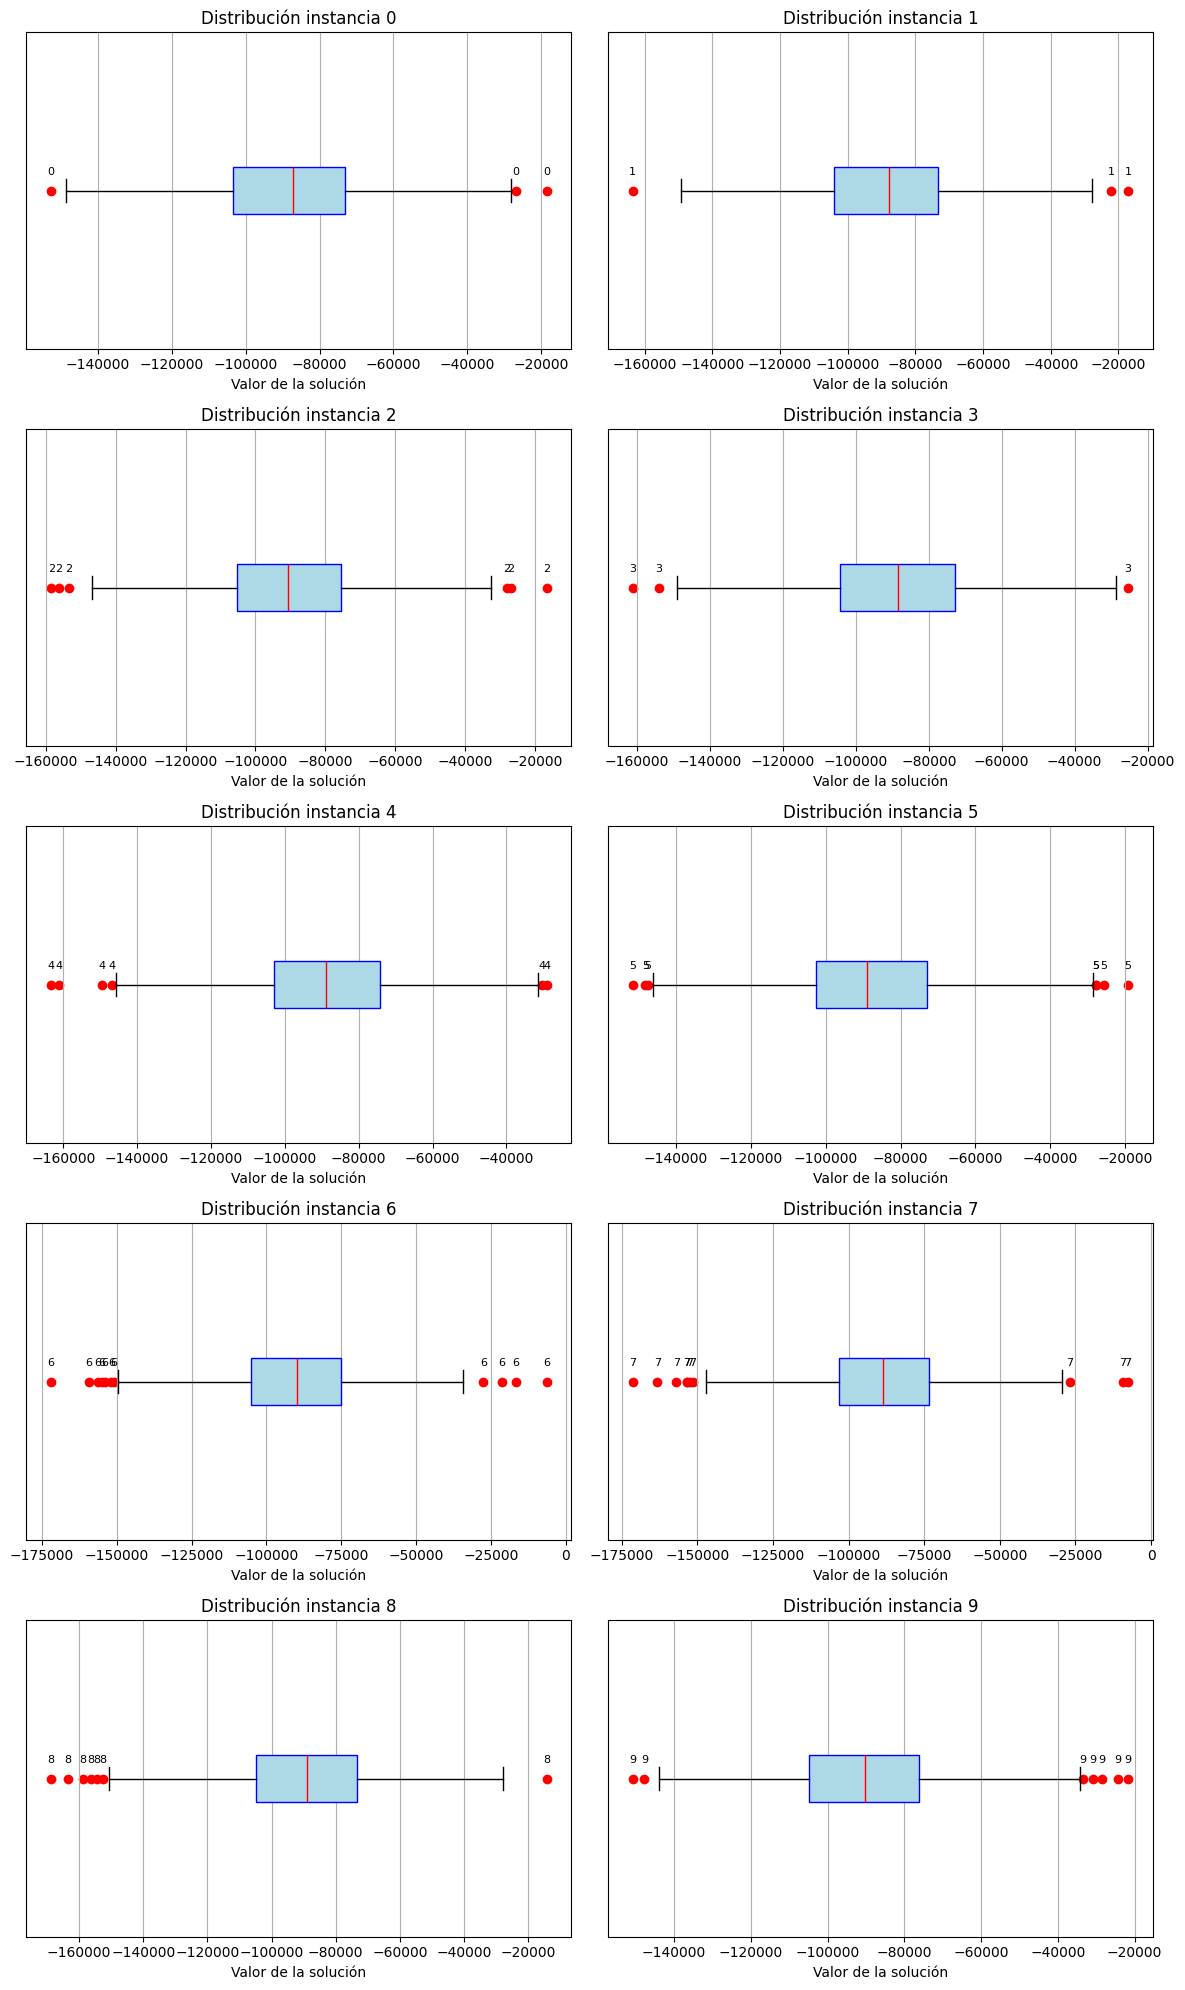

In [63]:
valores_hienas_faciles = df_faciles["Valores de las presas"]

n = len(valores_hienas_faciles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_faciles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


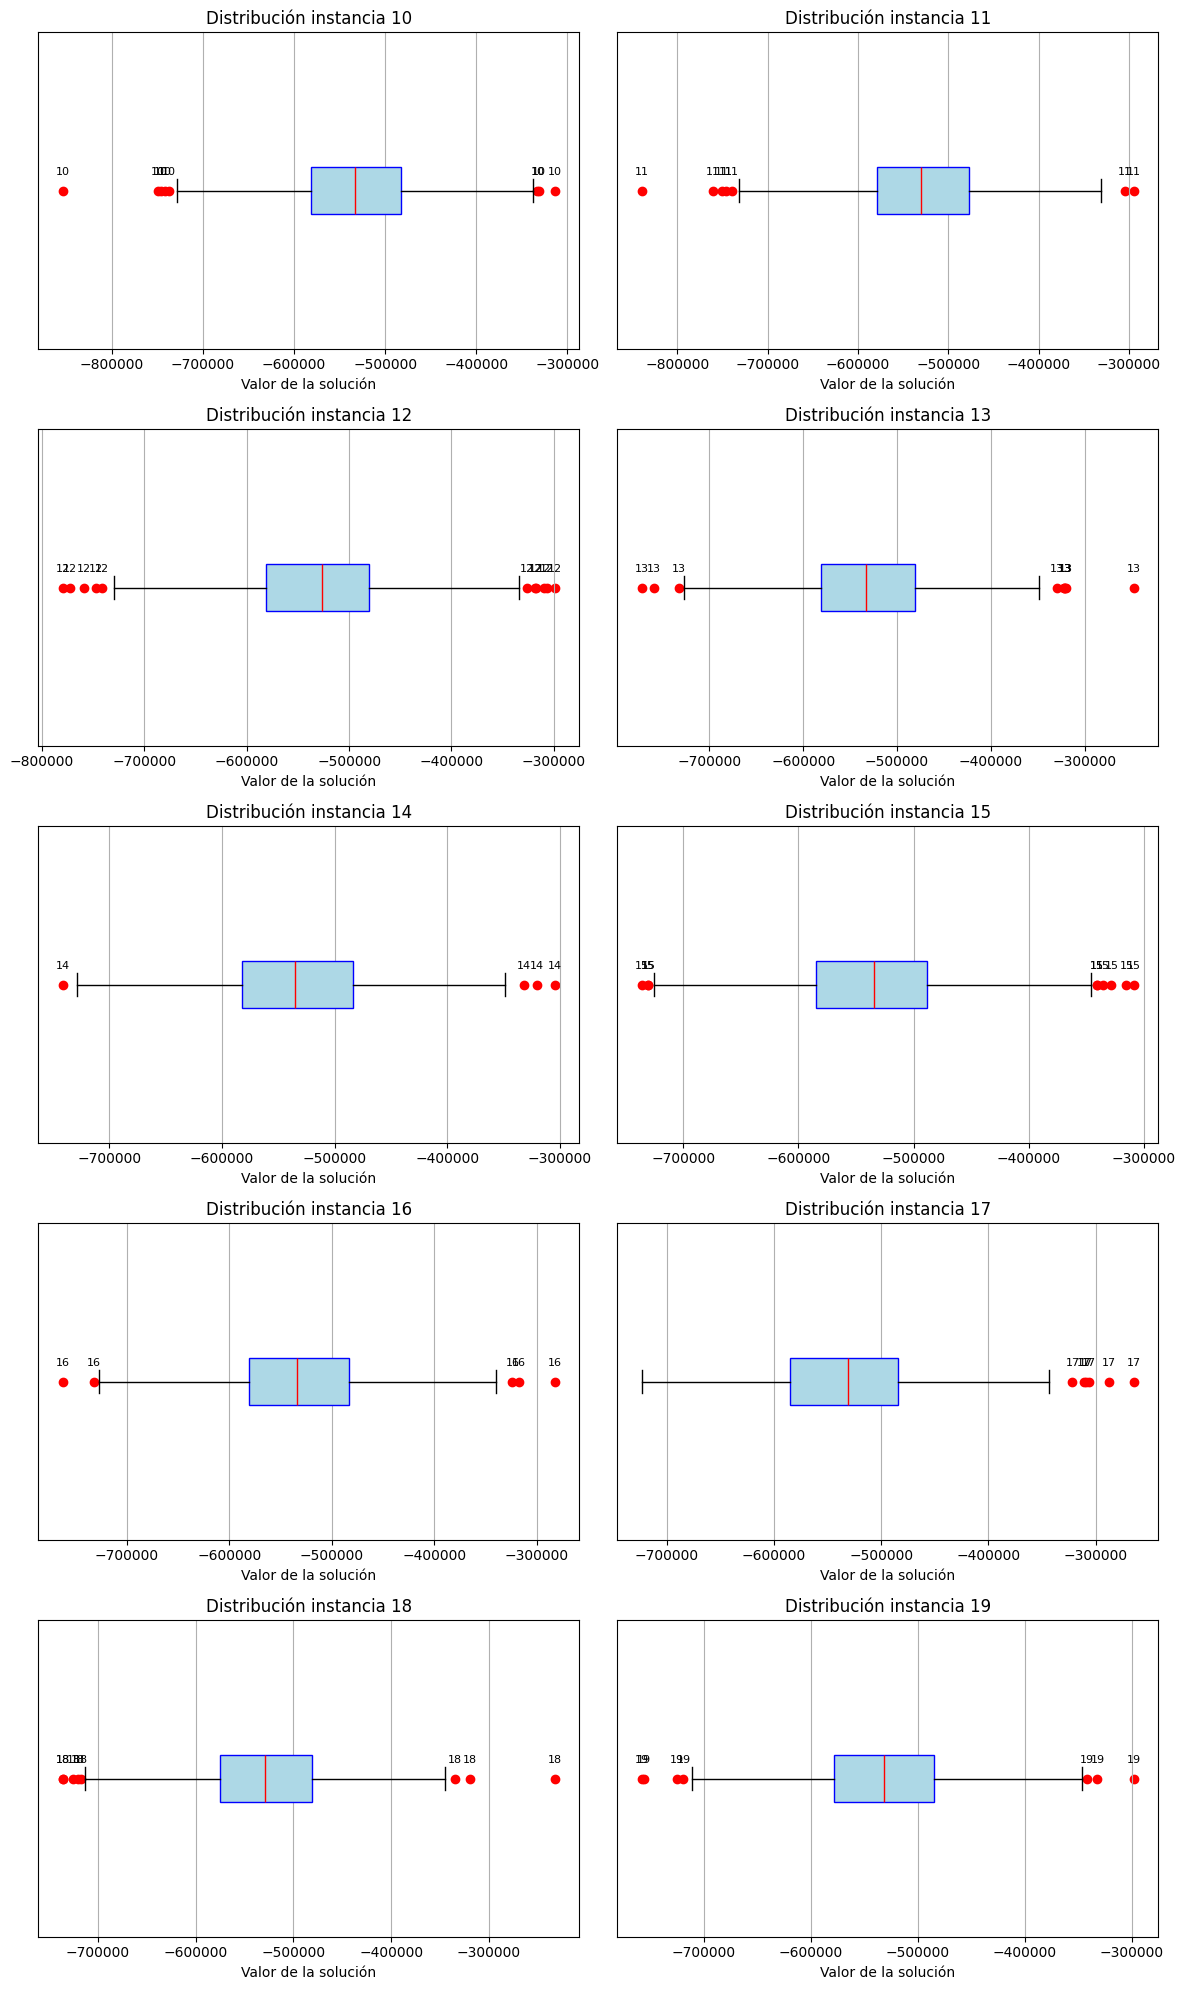

In [62]:
valores_hienas_medios = df_medios["Valores de las presas"]

n = len(valores_hienas_medios)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_medios):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+10}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+10}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


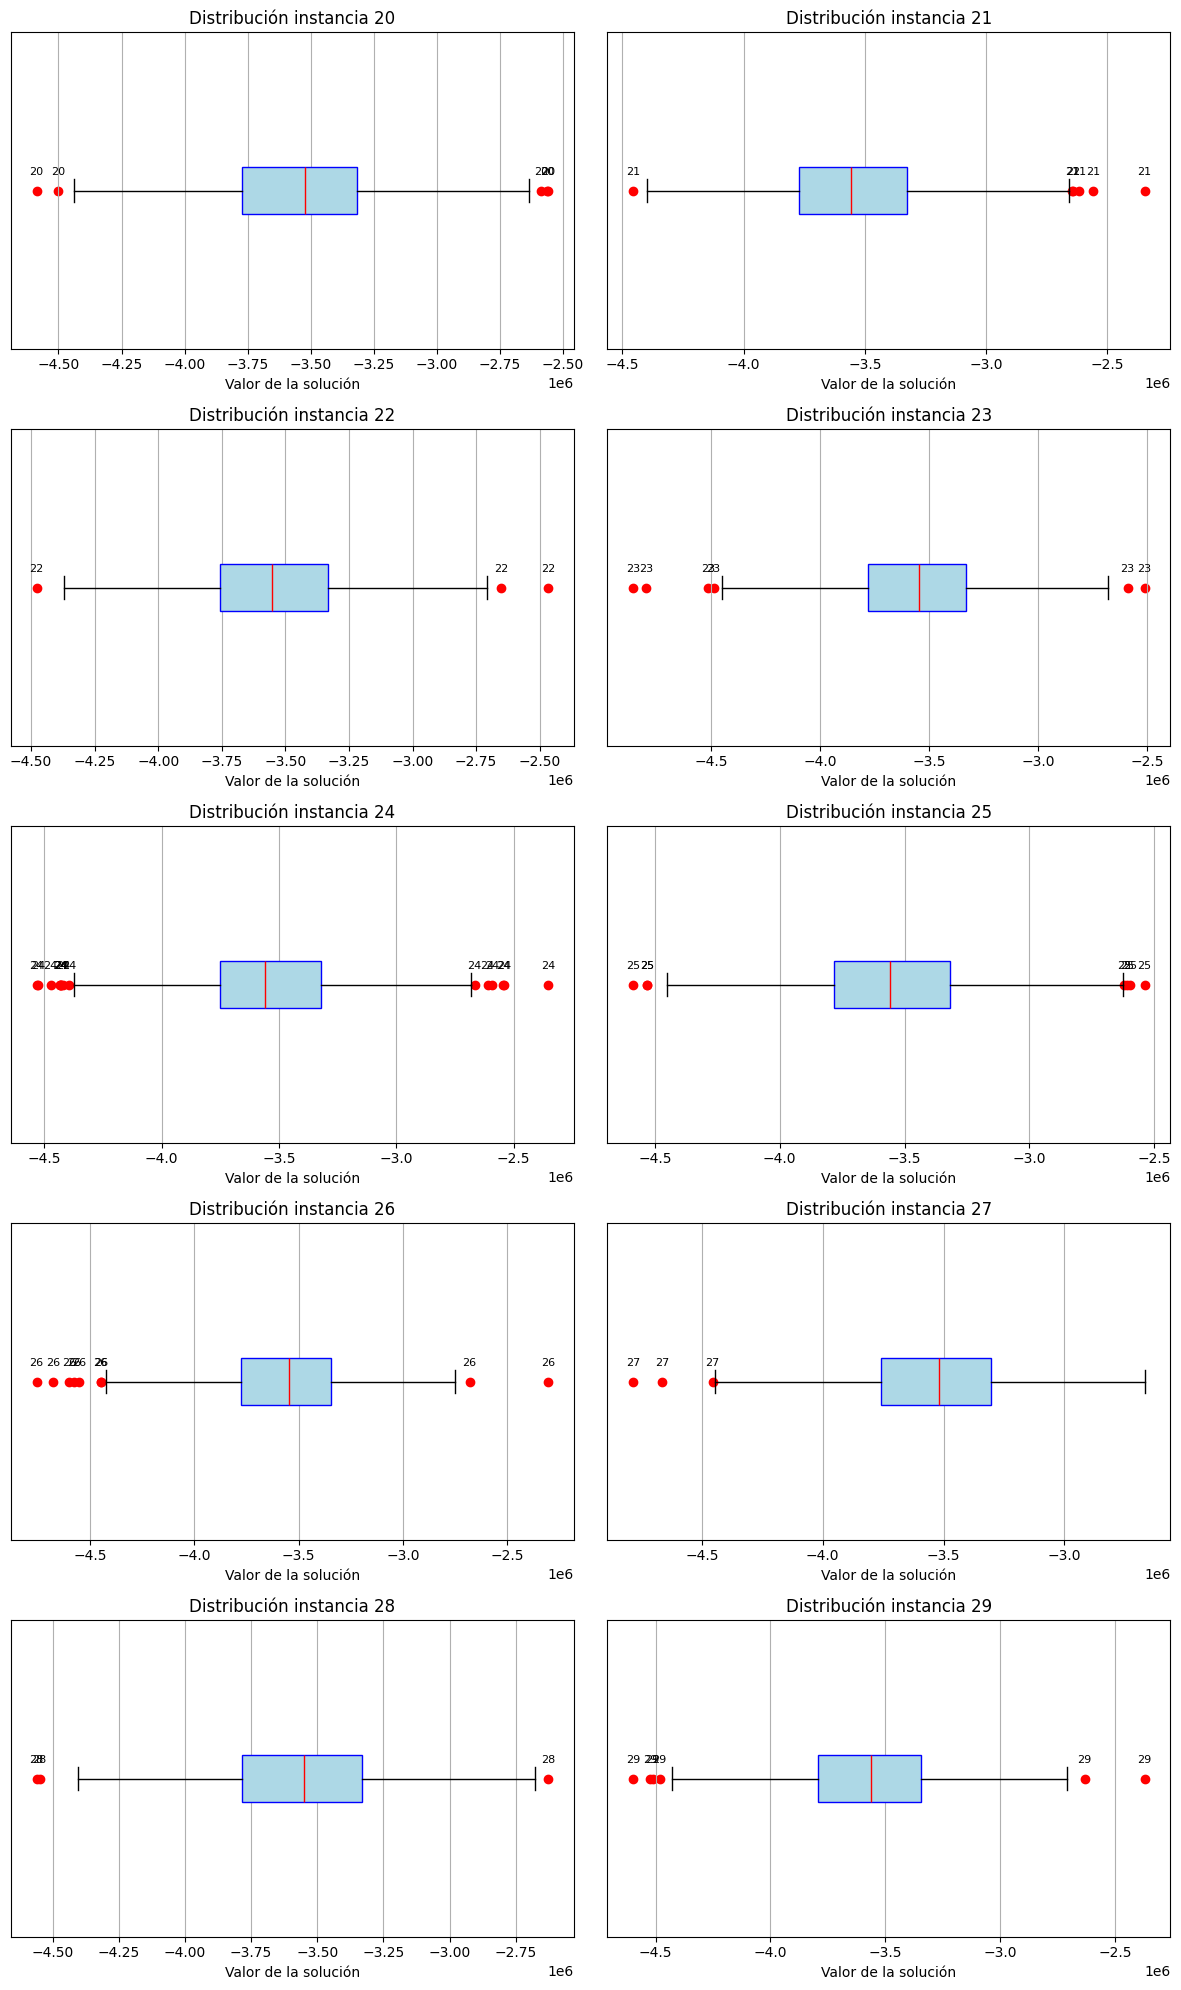

In [64]:
valores_hienas_dificiles = df_dificiles["Valores de las presas"]

n = len(valores_hienas_dificiles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_dificiles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


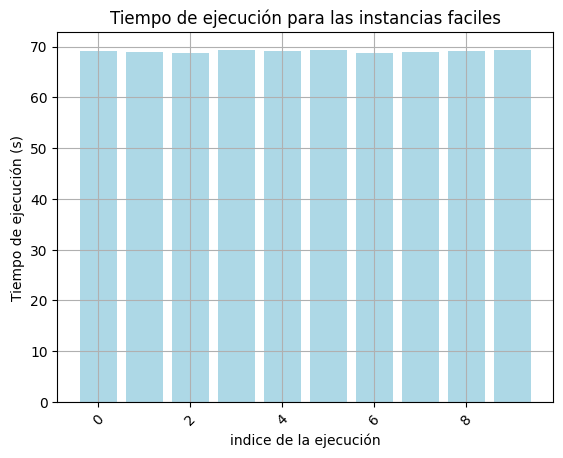

In [66]:
# Tiempo de ejecución para las instancias fáciles
plt.bar(df_faciles.index, df_faciles["Tiempo de ejecución"], label='Fácil', color='lightblue')
plt.title('Tiempo de ejecución para las instancias faciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

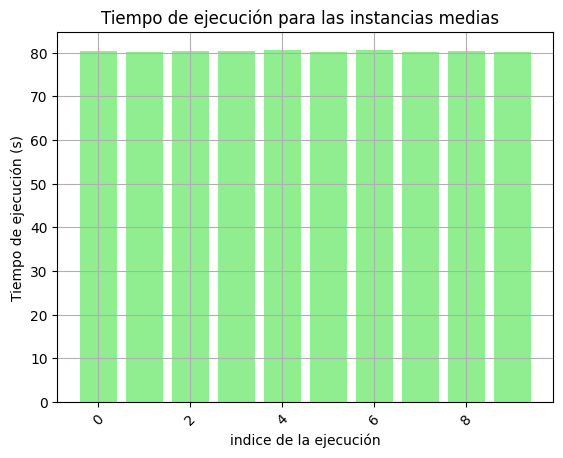

In [65]:
# Tiempo de ejecución para las instancias medias
plt.bar(df_faciles.index, df_medios["Tiempo de ejecución"], label='Media', color='lightgreen')
plt.title('Tiempo de ejecución para las instancias medias  ')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

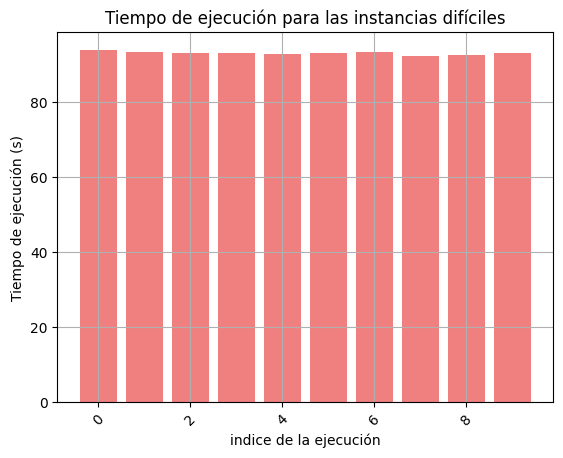

In [67]:
# Tiempo de ejecución para las instancias difíciles
plt.bar(df_faciles.index, df_dificiles["Tiempo de ejecución"], label='Difícil', color='lightcoral')
plt.title('Tiempo de ejecución para las instancias difíciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Experimentos replicados

## Experimento de las 100 hienas

In [27]:
df_100 = pd.read_csv("resultados_sho_binario_100_hienas.csv")

In [ ]:
df_100["% de mejora"] = (df_100["Mejor"] - df_100["Presa inicial"]) / np.abs(df_100["Presa inicial"]) * 100
df_100["Mean"] = df_100["Mejor"].mean().__round__(2)
df_100["Std deviation"] = df_100["Mejor"].std()
df_100["Valores de las presas"] = df_100["Valores de las presas"].apply(convert_list_string)

In [35]:
df_100_faciles = df_100.loc[df_100['Instancia'] == 'Fácil']
df_100_medios = df_100.loc[df_100['Instancia'] == 'Media']
df_100_dificiles = df_100.loc[df_100['Instancia'] == 'Difícil']

## Graficos

### 100 hienas, instancia facil

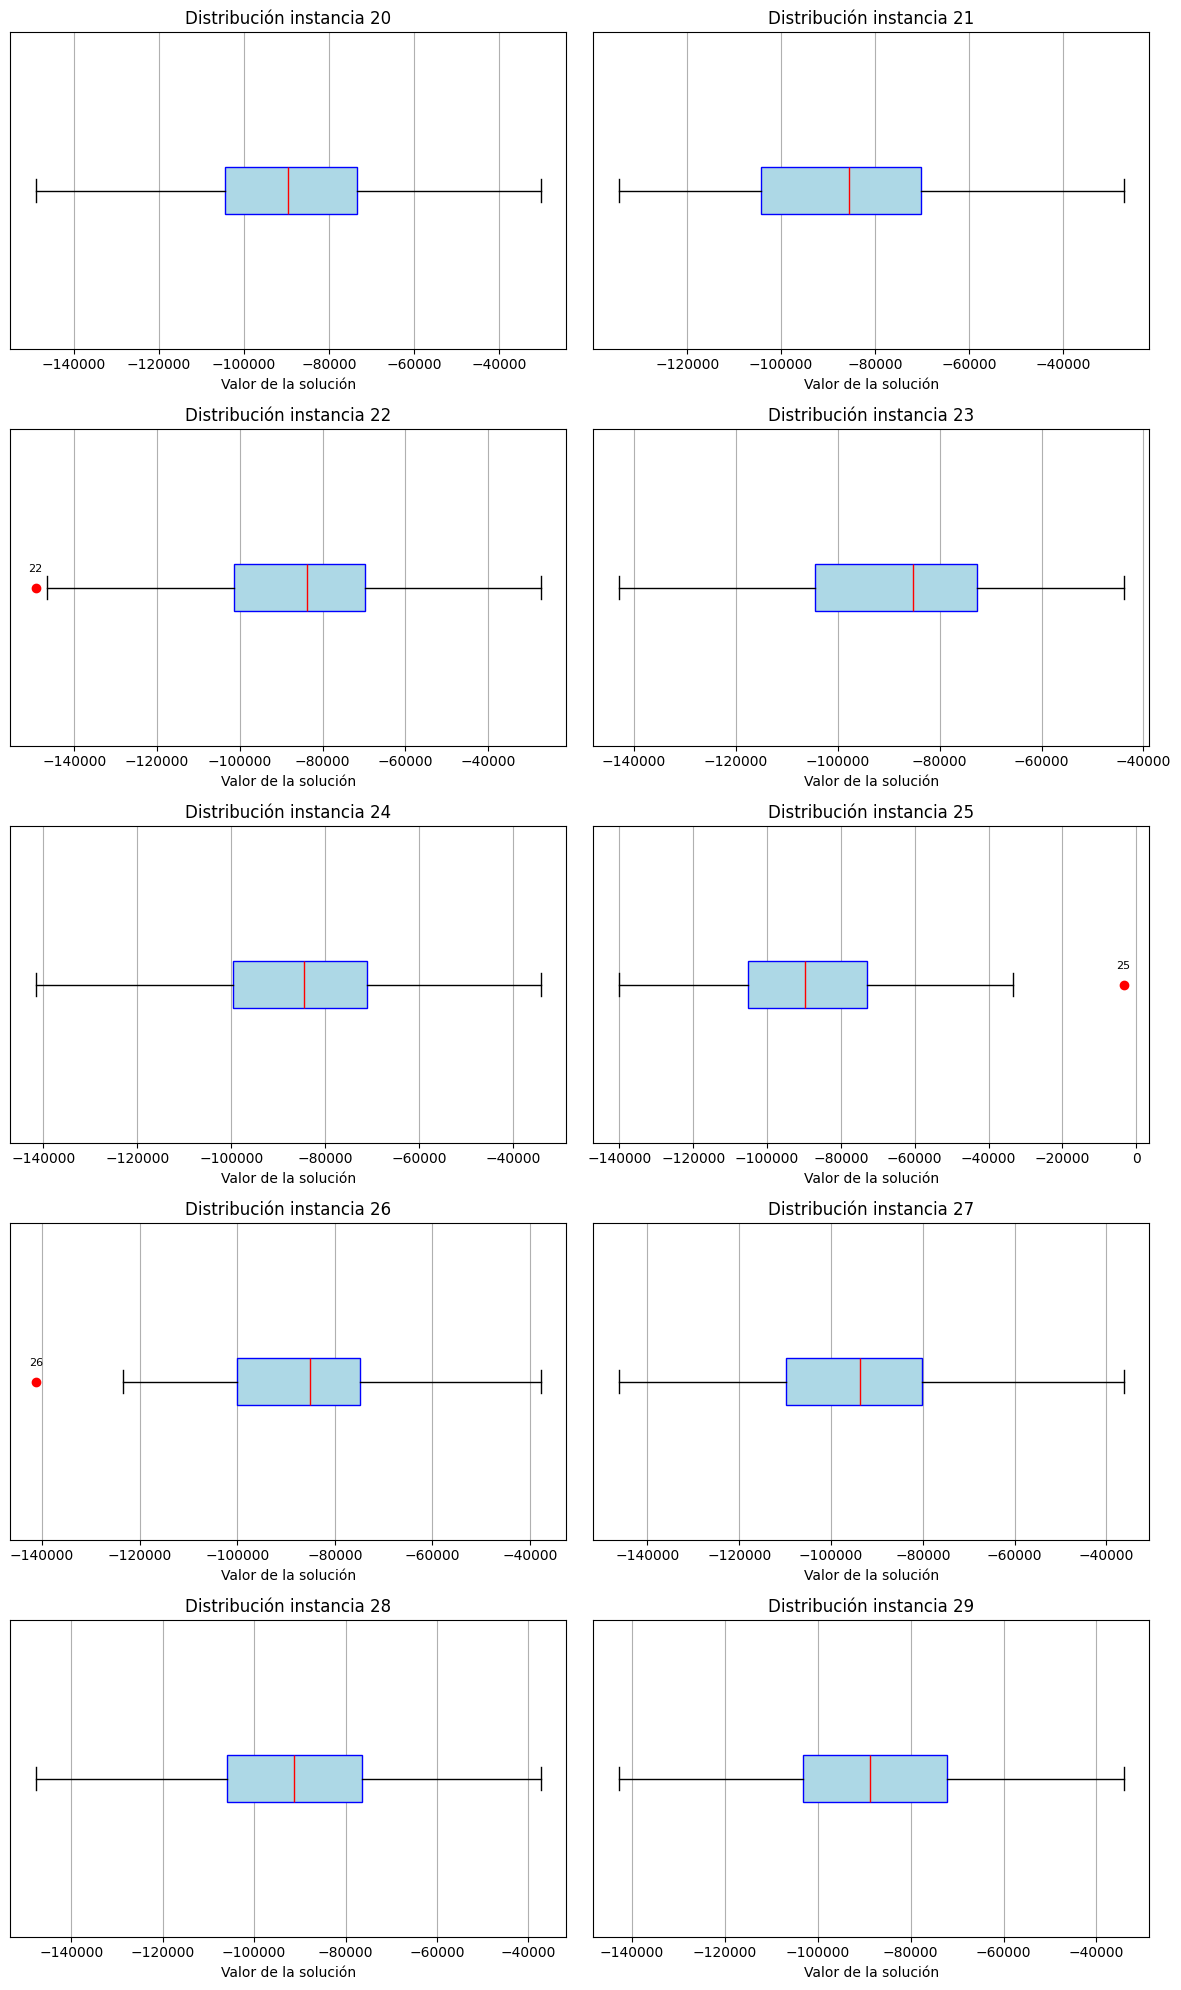

In [36]:
valores_100_hienas_faciles = df_100_faciles["Valores de las presas"]

n = len(valores_100_hienas_faciles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_100_hienas_faciles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 100 hienas, instancia media

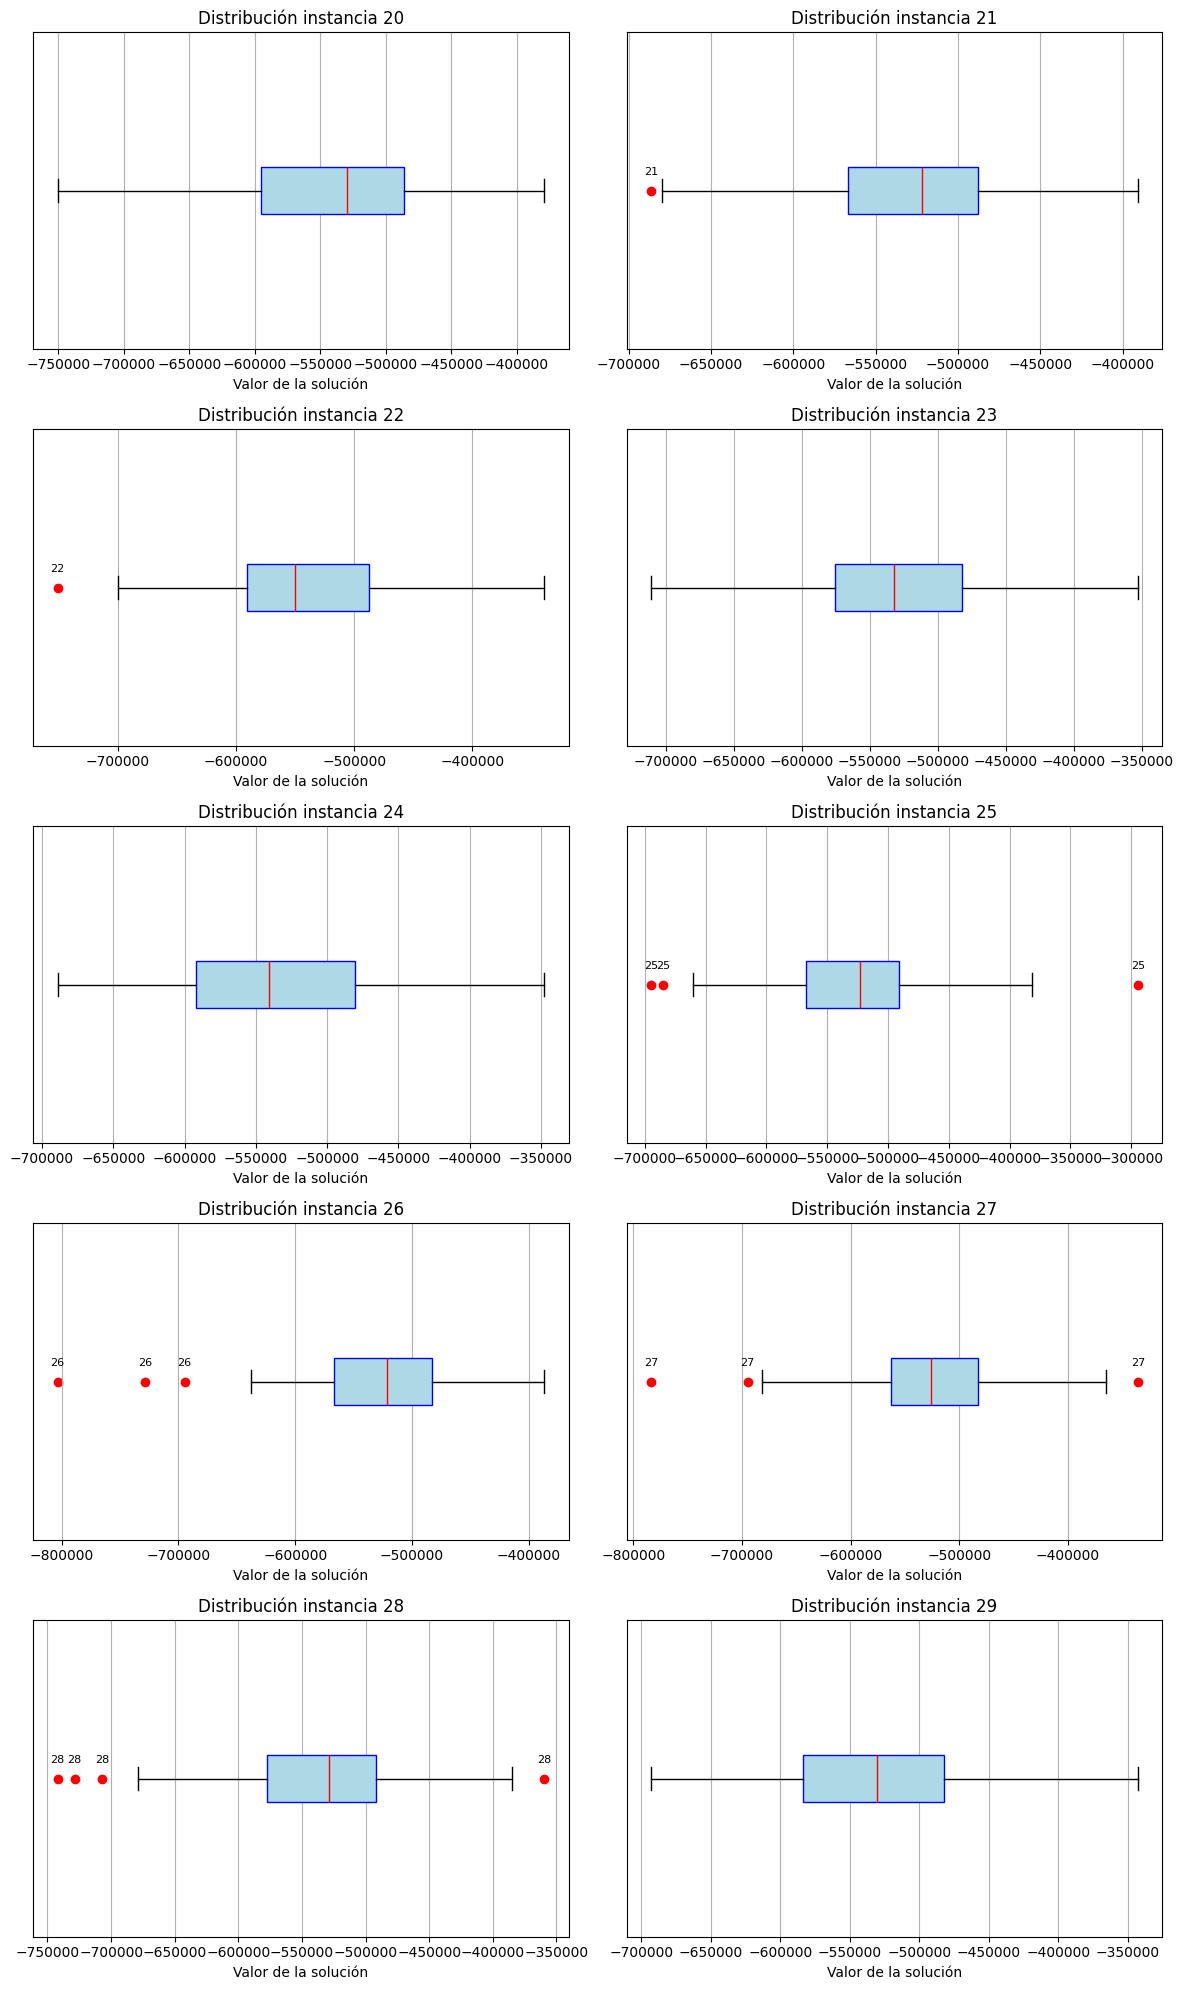

In [37]:
valores_100_hienas_medios = df_100_medios["Valores de las presas"]

n = len(valores_100_hienas_medios)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_100_hienas_medios):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 100 hienas, instancia dificil

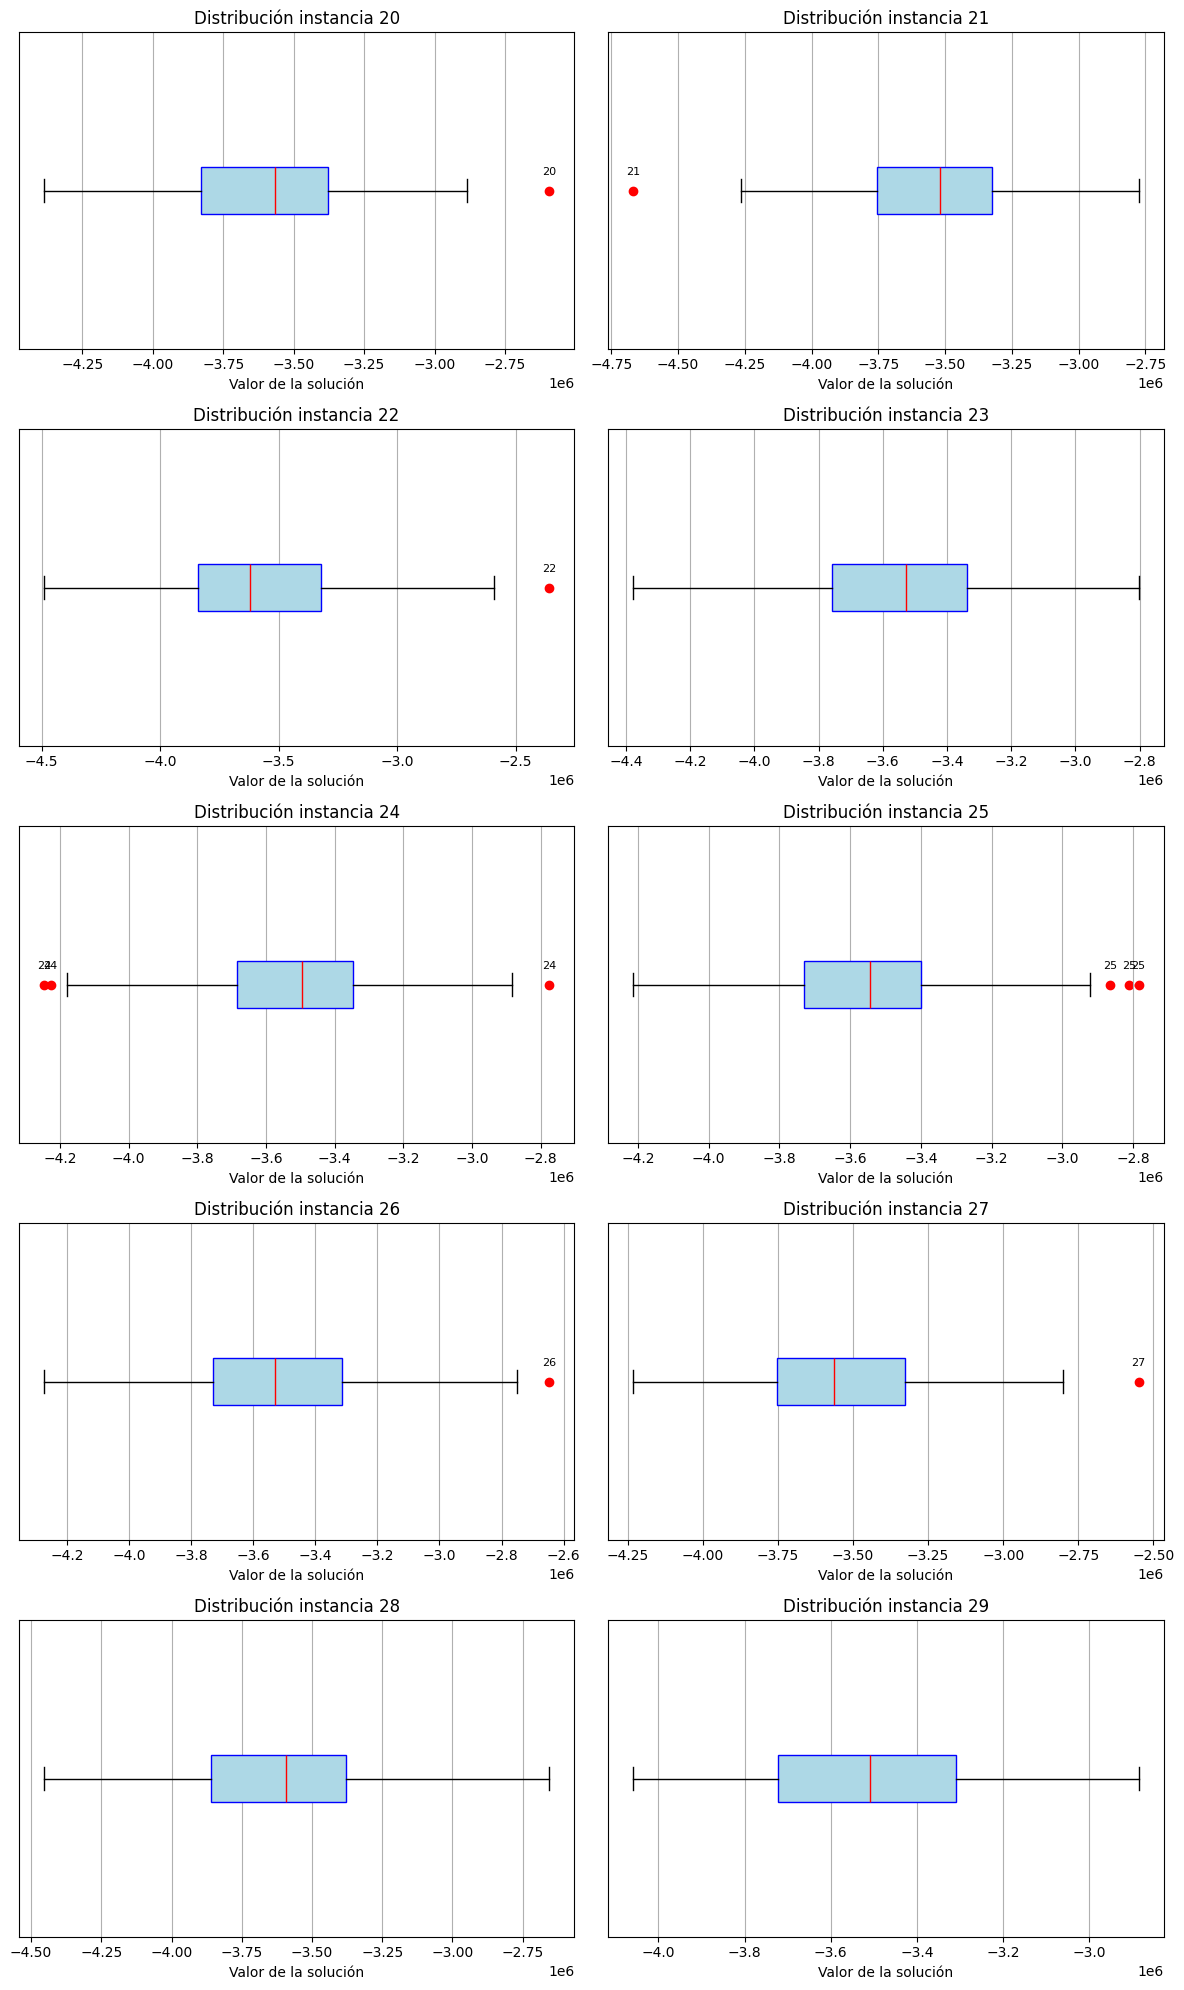

In [39]:
valores_100_hienas_dificiles = df_100_dificiles["Valores de las presas"]

n = len(valores_100_hienas_dificiles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_100_hienas_dificiles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Experimentos 1000 hienas

In [42]:
df_1000 = pd.read_csv("resultados_sho_binario_1000_hienas.csv")

In [43]:
df_1000["% de mejora"] = (df_1000["Mejor"] - df_1000["Presa inicial"]) / np.abs(df_1000["Presa inicial"]) * 100
df_1000["Mean"] = df_1000["Mejor"].mean().__round__(2)
df_1000["Std deviation"] = df_1000["Mejor"].std()
df_1000["Valores de las presas"] = df_1000["Valores de las presas"].apply(convert_list_string)

In [45]:
df_1000_faciles = df_1000.loc[df_1000['Instancia'] == 'Fácil']
df_1000_medios = df_1000.loc[df_1000['Instancia'] == 'Media']
df_1000_dificiles = df_1000.loc[df_1000['Instancia'] == 'Difícil']

### 1000 hienas, instacia facil


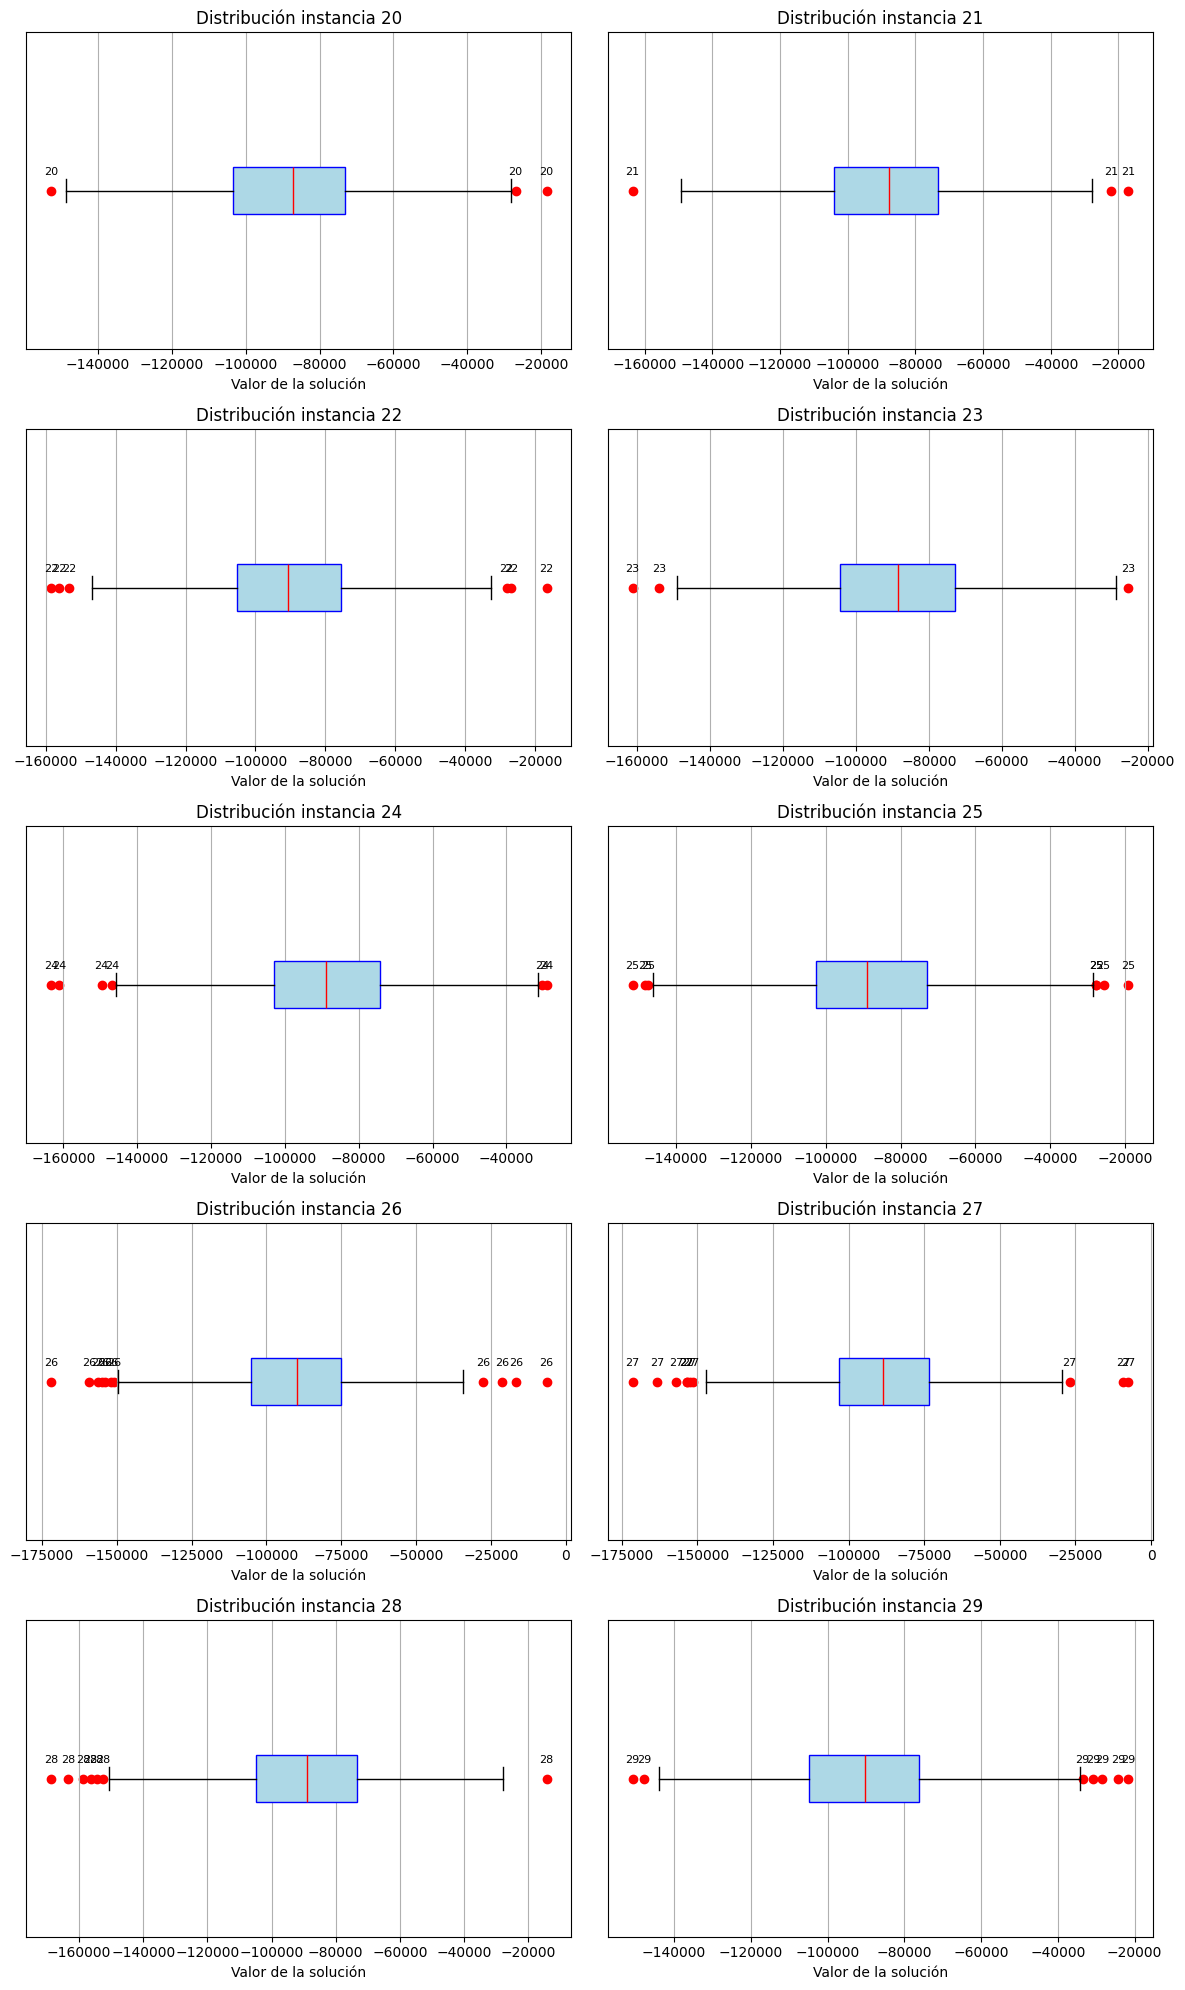

In [46]:
valores_1000_hienas_faciles = df_1000_faciles["Valores de las presas"]

n = len(valores_1000_hienas_faciles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_1000_hienas_faciles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 1000 hienas, instancia media

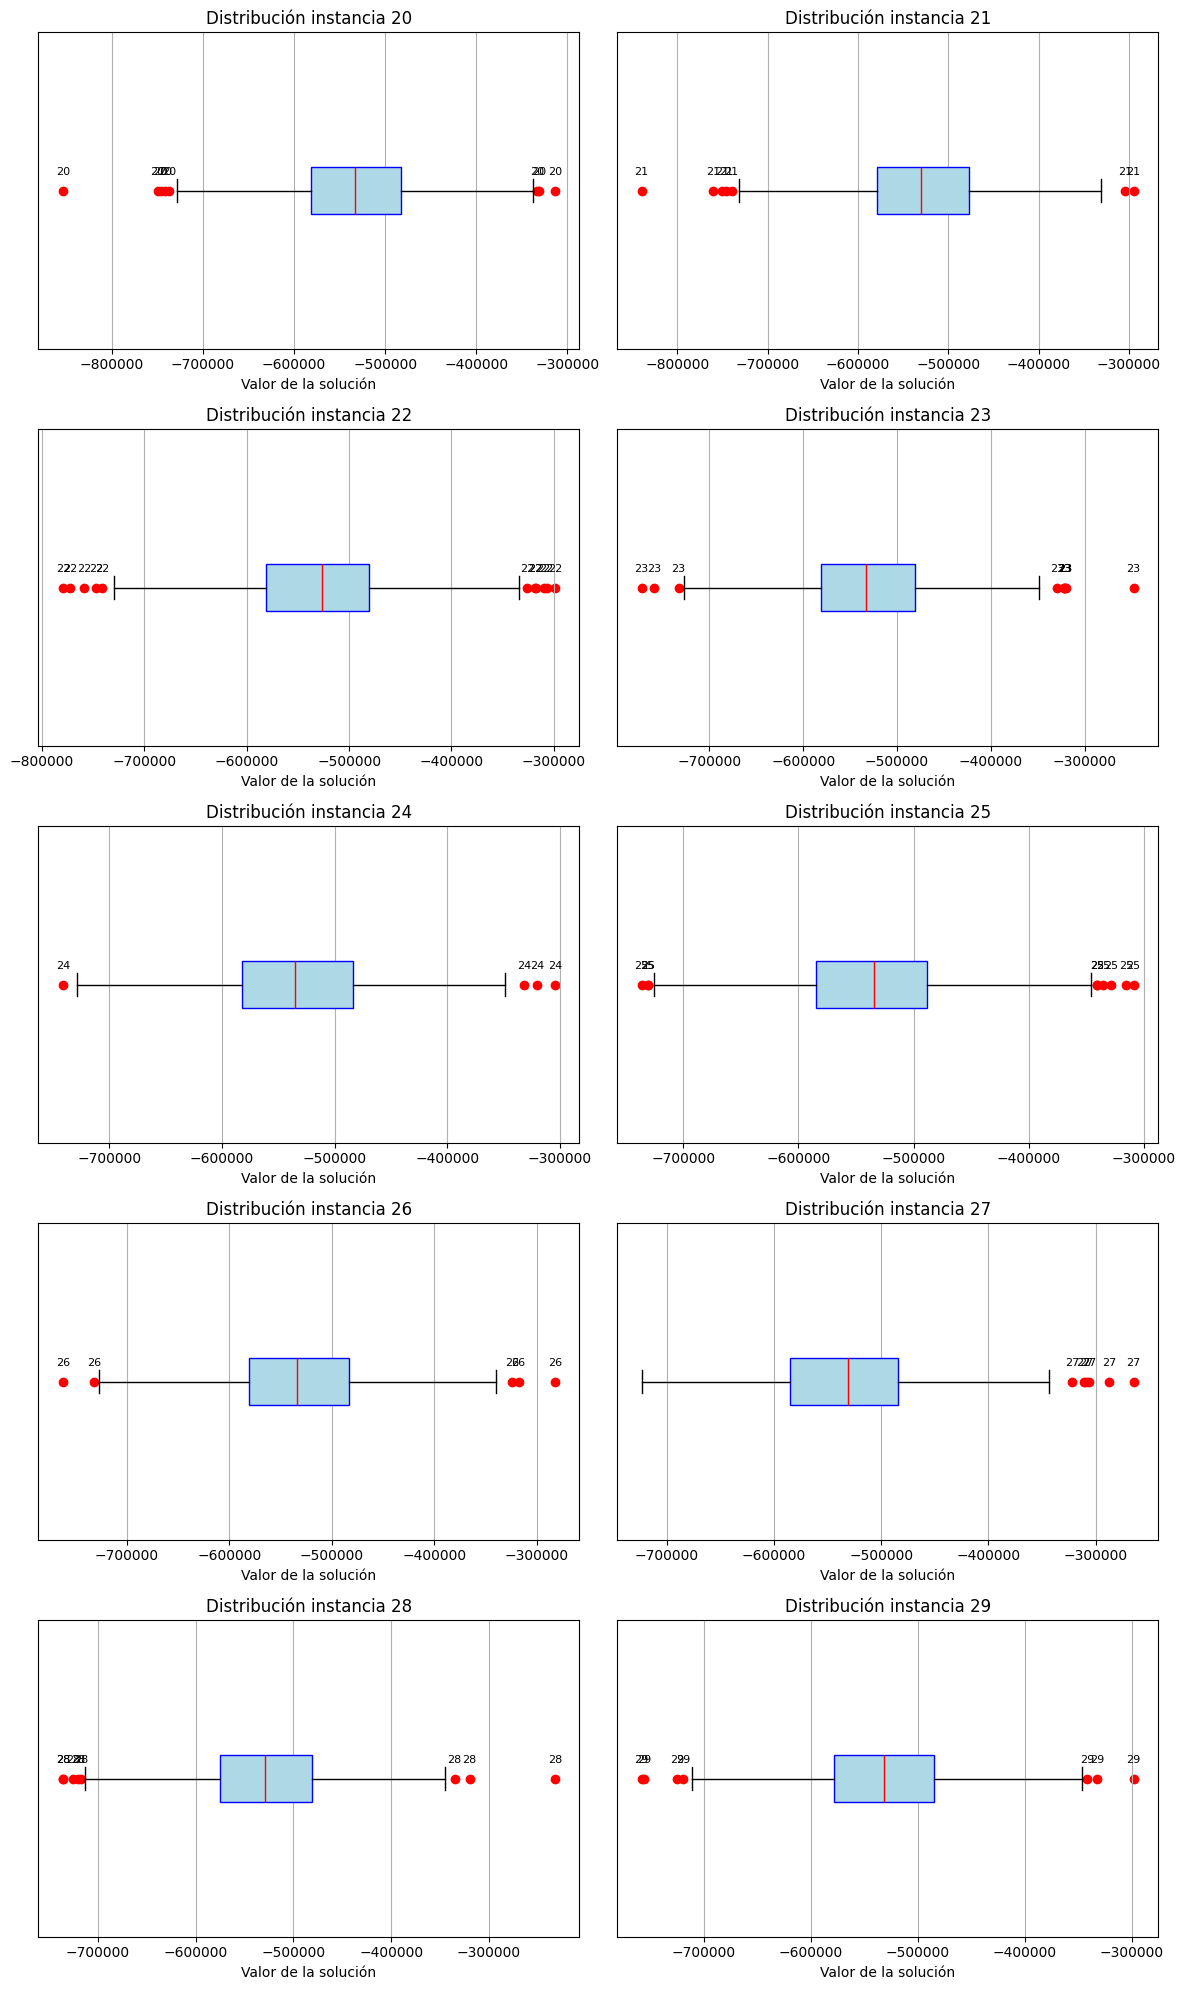

In [47]:
valores_1000_hienas_medios = df_1000_medios["Valores de las presas"]

n = len(valores_1000_hienas_medios)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_1000_hienas_medios):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1000 hienas, instancia dificil

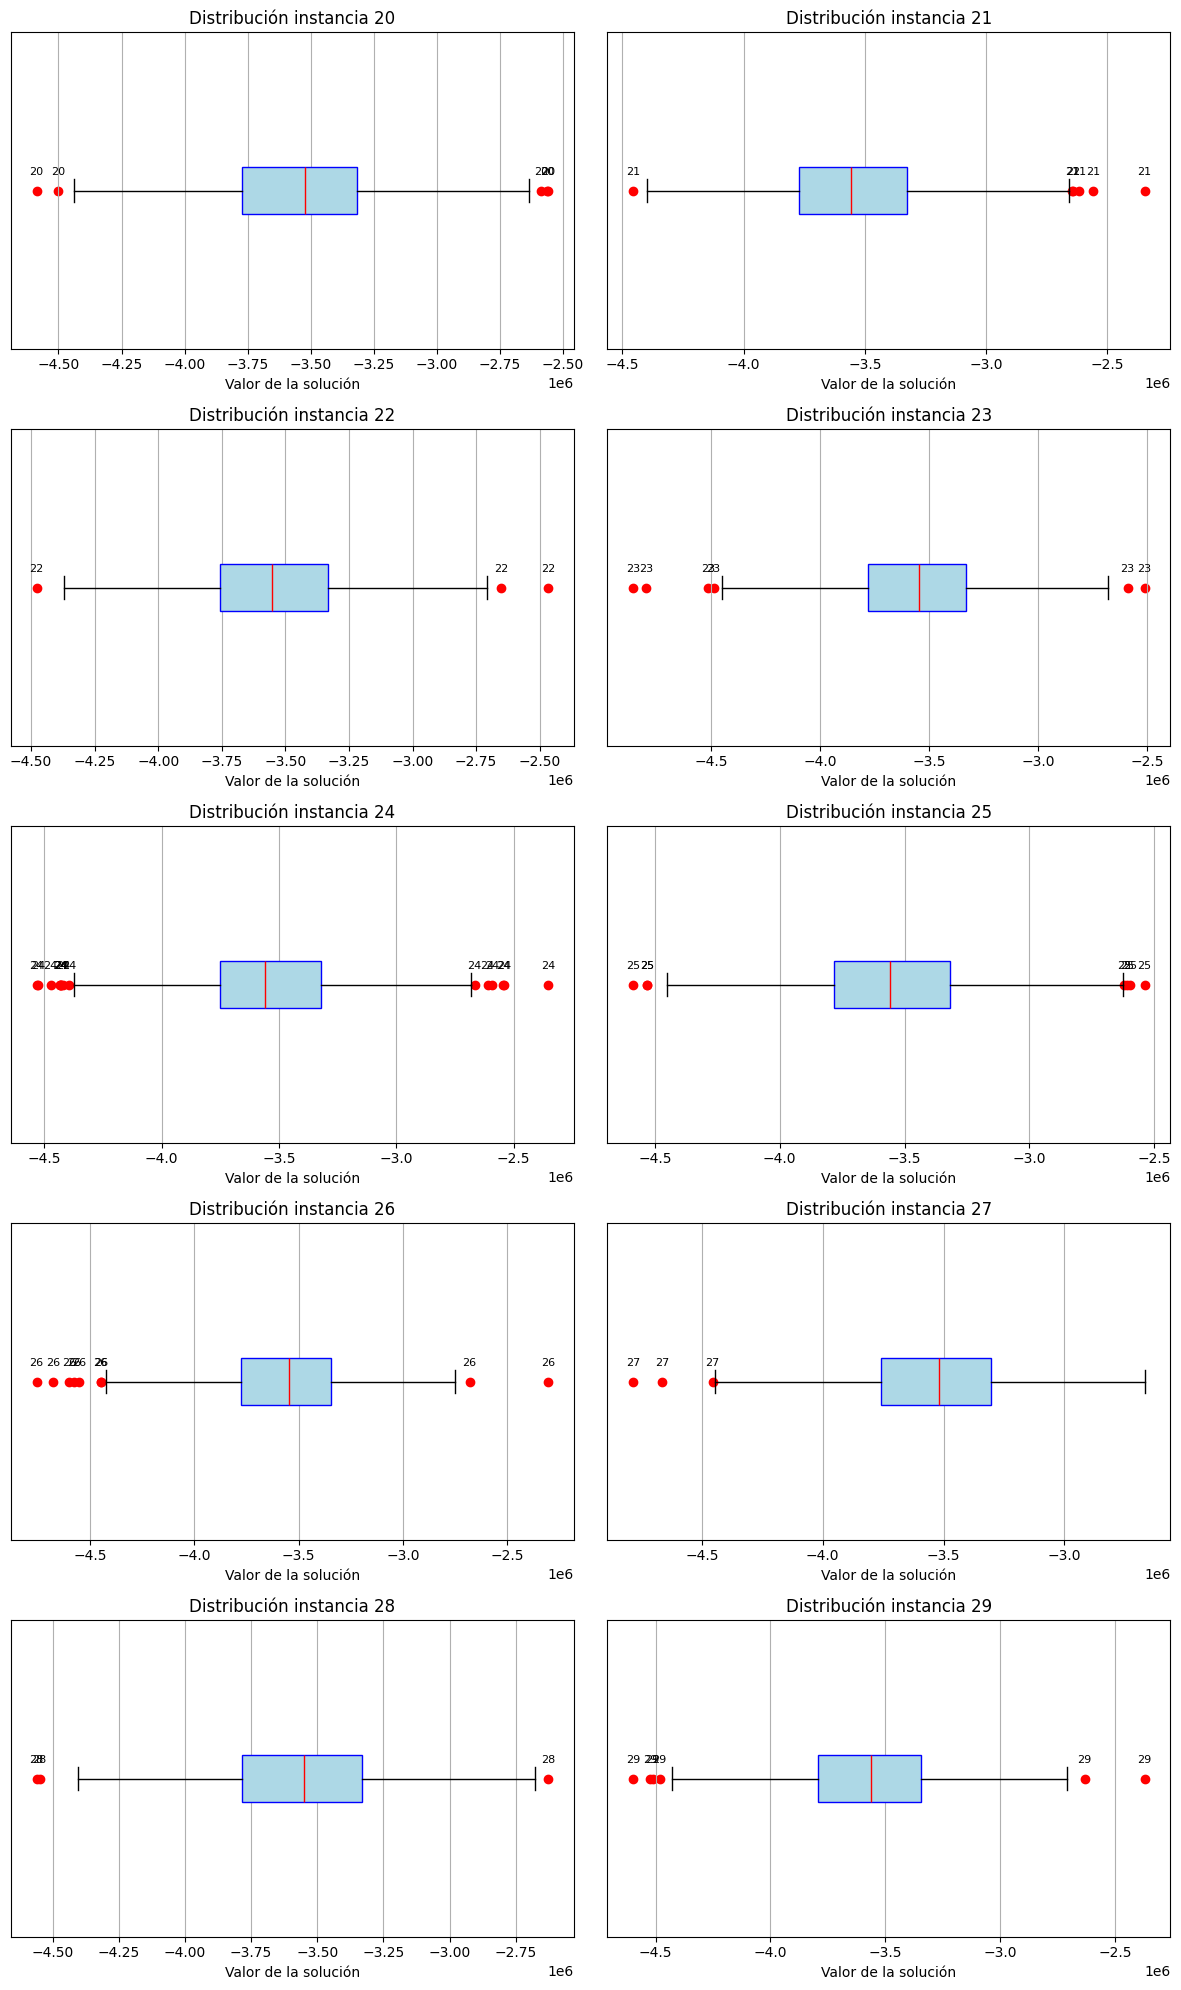

In [48]:
valores_1000_hienas_dificiles = df_1000_dificiles["Valores de las presas"]

n = len(valores_1000_hienas_dificiles)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_1000_hienas_dificiles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+20}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+20}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()